---
title: "A River's History Visualized"
description: "Visualizing the meanderings of the Snake River in Grand Teton National Park using a relative elevation model" 
author: "Colin Hill"
date: "2024-11-03"
categories: [Visualization, DEM, Xarray, GeoPandas, Python]
page-layout: article
image: rem.png
---

A wonderful aspect of geospatial data is that it's both beautiful and informative. In this post I look at the migration of the Snake River in Grand Teton National Park, USA over time by creating a relative elevation model (REM). This takes a digital elevation model (DEM) and de-trends the baseline elevation so it follows the water's surface. By doing so, we can clearly see the migration of the river's channels and the associated features such as oxbow lakes, meander scars and terraces.

This post was inspired by this [blog post](https://dancoecarto.com/creating-rems-in-qgis-the-idw-method) and [this notebook](https://hyriver.readthedocs.io/en/latest/examples/notebooks/rem.html), and makes use of the [HyRiver](https://hyriver.readthedocs.io/) suite of package for data access: [PyNHD](https://hyriver.readthedocs.io/en/latest/readme/pynhd.html) for river flowlines and [Py3DEP](https://hyriver.readthedocs.io/en/latest/readme/py3dep.html) for a high resolution DEM.

In [1]:
# Define AOI bounding box

# Snake River, Grand Teton National Park
bbox = [-110.583466, 43.790715, -110.509222, 43.848585] # WSG84 coordinates, WSEN

For the first step we will retrieve the river's path. We can retrieve the river's flowline (geometry) from USGS data which is easily accessible using the [PyNHD](https://hyriver.readthedocs.io/en/latest/readme/pynhd.html) package

In [2]:
#| code-fold: true
import pynhd
import py3dep
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyproj
import numpy as np
import pygeoutils
import xarray as xr
from scipy.spatial import KDTree

In [3]:
# Connect to service 
water_data = pynhd.WaterData("nhdflowline_network")

# Get flowlines within bounding box
flowlines = water_data.bybox(bbox)

In [4]:
# This returns a GeoDataFrame
flowlines.head(2)

,geometry,comid,fdate,resolution,gnis_id,gnis_name,lengthkm,reachcode,flowdir,wbareacomi,...,qc_12,vc_12,qe_12,ve_12,lakefract,surfarea,rareahload,rpuid,vpuid,enabled
0,"MULTILINESTRING Z ((-110.54139 43.79185 0, -11...",23123173,2005-07-21T04:00:00Z,Medium,,,3.651,17040101000094,With Digitized,0,...,0.132,0.53390,0.132,0.53390,NaN,NaN,NaN,17a,17,1
1,"MULTILINESTRING Z ((-110.54022 43.79151 0, -11...",23123175,2001-02-07T05:00:00Z,Medium,1603229,Spread Creek,0.102,17040101000095,With Digitized,0,...,68.385,1.23836,68.385,1.23836,NaN,NaN,NaN,17a,17,1


We want to keep the main stream only, which in this case we can easily do by filtering on the `gnis_name`

In [5]:
flowline = flowlines.loc[flowlines['gnis_name'].eq('Snake River')]

In [6]:
# Plot flowlines and bounding box

# Create GeoDataframe with bounding box
gdf_bbox = gpd.GeoDataFrame(data={'geometry': shapely.box(*bbox)}, index=[0], crs='EPSG:4326')
m = flowlines.explore(color='blue')
flowline.explore(color='red', m=m)
gdf_bbox.explore(color="black", style_kwds={"fillColor": "None"}, m=m)
m

For the next step, we'll retrieve a DEM for the region. For this we can use the [Py3DEP](https://hyriver.readthedocs.io/en/latest/readme/py3dep.html) package which gives us easy access to the [USDA 3DEP database](https://www.usgs.gov/3d-elevation-program)

In [7]:
# Check which resolutions are available in our AOI
dem_resolutions = py3dep.check_3dep_availability(bbox)
dem_resolutions


{'1m': True,
 '3m': True,
 '5m': False,
 '10m': True,
 '30m': True,
 '60m': False,
 'topobathy': False}

DEM data is available at up to `1m` resolution, however we'll use `3m` to save time and computation. We can simply use `py3dep.get_dem` to download data for our AOI and chosen resolution and return an `xarray.DataArray` 

In [8]:
dem = py3dep.get_dem(bbox, resolution=3, crs=flowline.crs)

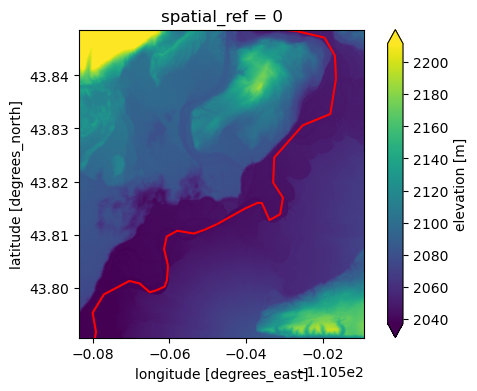

In [13]:
# Plot DEM with river overlayed
fig, ax = plt.subplots(figsize=(6, 4))
dem.plot(ax=ax, robust=True);
flowline.plot(ax=ax, color="r");

To de-trend the DEM, we need to find the elevation profile along the river's flowline. While `py3dep.elevation_profile` provides this functionality, it uses the `10m` DEM, and as we already have `3m` data we can use it instead with a little extra work.

In [14]:
# First combine all geometries to a single MultiLineString
line = shapely.union_all(flowline.line_merge())

# Smooth the line to 3m spacing and extract height from the DEM

# Reproject to meters
project = pyproj.Transformer.from_crs(flowline.crs, 5070, always_xy=True).transform
line_5070 = shapely.ops.transform(project, line)

# Smooth line
spacing = 3 # 3m spacing
npts = int(np.ceil(line_5070.length / spacing))
line_5070_smooth = pygeoutils.smooth_linestring(line_5070, 0.1, npts)

# Reproject back to original crs
project = pyproj.Transformer.from_crs(5070, flowline.crs, always_xy=True).transform
line_smooth = shapely.ops.transform(project, line_5070_smooth)

# Extract elevation from DEM
xs, ys = line_smooth.xy
xs, ys = xr.DataArray(xs, dims='distance'), xr.DataArray(ys, dims='distance')
river_dem = dem.interp(x=xs, y=ys, method='nearest').dropna(dim='distance')

To mitigate artifacts arising from the river geometry and DEM not matching (due to natural change over time), we can ensure that the river elevation decreases or stays constant between pixels

In [15]:
# Ensure the elevation is non-increasing
river_dem.values = np.minimum.accumulate(river_dem.values)

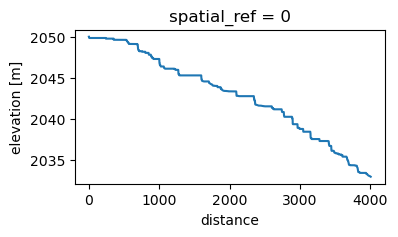

In [16]:
river_dem.plot(figsize=(4, 2));

Now we need to interpolate the height of the river over the entire AOI. We can do this using the inverse distance weighting (IDW) method.

In [17]:
#| code-fold: true
def idw(da_in: xr.DataArray, da_out: xr.DataArray, k: int = 10, n: float = 1) -> xr.DataArray:
    """
    Inverse distance weighted interpolation
    
    Args:
        da_in: Input data to interpolate
        da_out: Output grid
        k: Number of nearest points to include
        n: Exponent of the weighting

    Returns:
        Interpolated data
    """
    coords = np.column_stack((da_in.x, da_in.y))
    kdt = KDTree(coords)

    grid = np.dstack(np.meshgrid(da_out.x, da_out.y)).reshape(-1, 2)
    distances, indices = kdt.query(grid, k=k)

    weights = np.power(np.reciprocal(distances), n)
    weights = weights / weights.sum(axis=1, keepdims=True)
    interp = weights * da_in.to_numpy()[indices]
    interp = interp.sum(axis=1).reshape((da_out.sizes["y"], da_out.sizes["x"]))
    interp = xr.DataArray(interp, dims=("y", "x"), coords={"x": da_out.x, "y": da_out.y})
    return interp

In [18]:
river_dem_interp = idw(river_dem, dem, k=200, n=0.5)

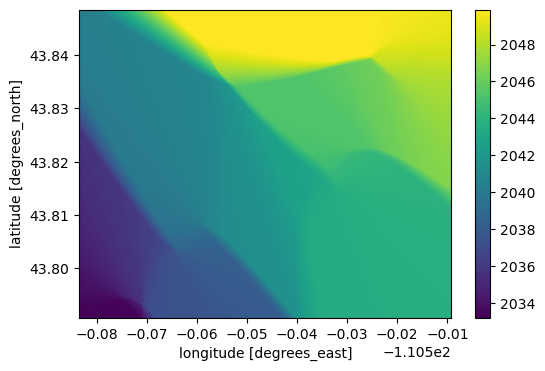

In [19]:
river_dem_interp.plot(figsize=(6, 4));

Finally, we can compute the REM from the river's elevation profile and the DEM

In [20]:
rem = dem - river_dem_interp

In [21]:
# To simplify plotting, set minimum to zero
rem = rem - rem.min()

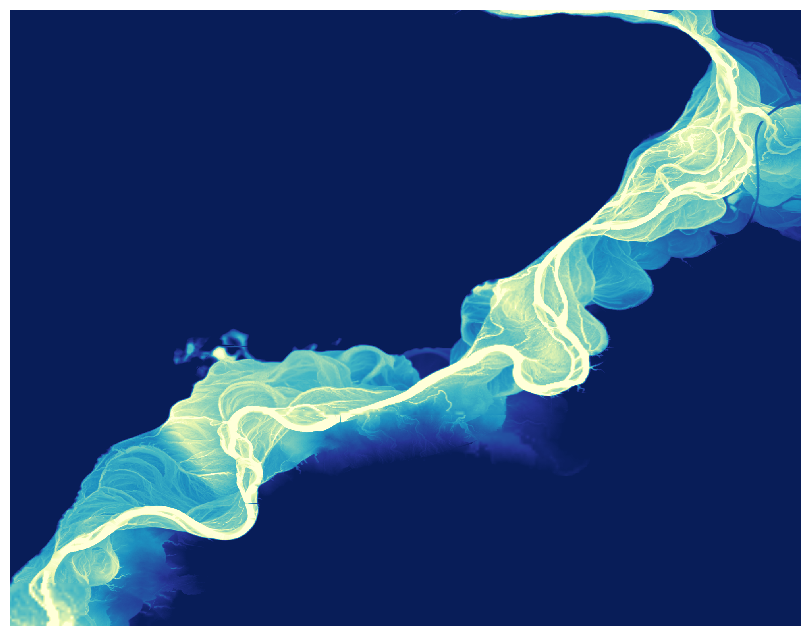

In [22]:
#| classes: preview-image
ax = rem.plot.imshow(figsize=(12,8), cmap="YlGnBu", norm=mpl.colors.LogNorm(vmin=1, vmax=10), add_colorbar=False, add_labels=False);
ax.axes.set_aspect('equal');
ax.axes.axis('off');
plt.savefig("rem.png", bbox_inches='tight', pad_inches=0, dpi=100)

We can clearly see the complex pattern of different paths the river has taken over the years, and the extent of the floodplains.